In [98]:
import pyspark
from pyspark.sql import SparkSession, types
from pyspark.sql.functions import max, col, unix_timestamp, desc

In [2]:
spark = SparkSession.builder \
    .master("local[*]") \
    .appName("test") \
    .getOrCreate()

23/03/10 09:20:17 WARN Utils: Your hostname, Anthonys-Mac-mini.local resolves to a loopback address: 127.0.0.1; using 192.168.68.107 instead (on interface en1)
23/03/10 09:20:17 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/03/10 09:20:18 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


##### Question 1

In [100]:
spark.version

'3.3.2'

##### Question 2

In [10]:
schema = types.StructType([
    types.StructField('dispatching_base_num', types.StringType(), True),
    types.StructField('pickup_datetime', types.TimestampType(), True),
    types.StructField('dropoff_datetime', types.TimestampType(), True),
    types.StructField('PULocationID', types.IntegerType(), True),
    types.StructField('DOLocationID', types.IntegerType(), True),
    types.StructField('SR_Flag', types.StringType(), True), 
    types.StructField('Affiliated_base_number', types.StringType(), True)
])

In [12]:
df = spark.read \
    .option("header", "true") \
    .schema(schema) \
    .csv("data/raw/fhvhv/fhvhv_tripdata_2021-06.csv")

In [18]:
df = df.repartition(12)
df.write.parquet("data/raw/fhvhv/parquet/")

23/03/10 09:34:27 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


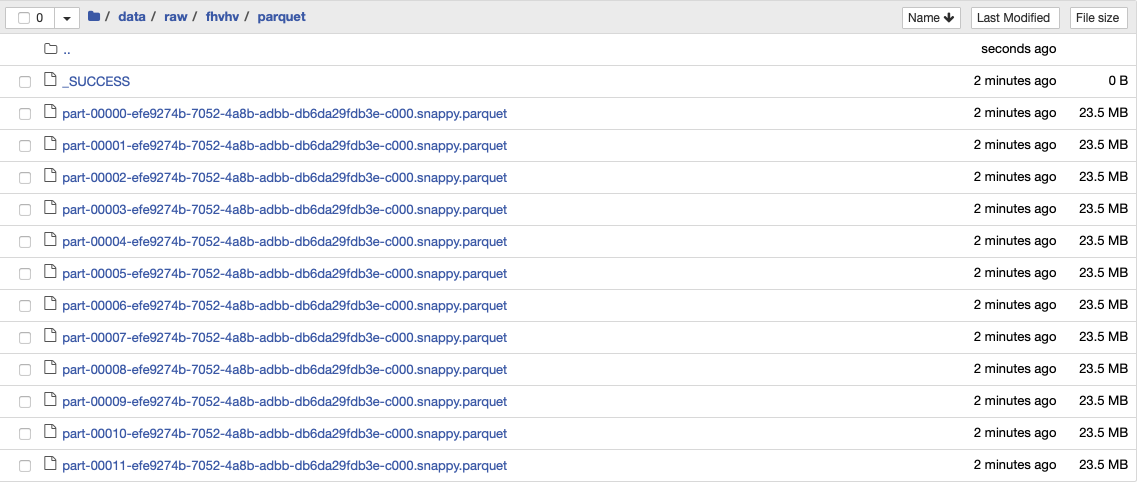

##### Question 3

In [47]:
df_filtered = df.filter((df.pickup_datetime >= "2021-06-15") \
            & (df.pickup_datetime < "2021-06-16"))

In [48]:
df_filtered.count()

452470

##### Question 4

In [68]:
df_duration = df.withColumn("trip_duration", \
            (unix_timestamp(col("dropoff_datetime")) - \
            unix_timestamp(col("pickup_datetime"))) / 60 / 60)

In [70]:
df_duration.select(max("trip_duration")) \
    .show(truncate=False)

+------------------+
|max(trip_duration)|
+------------------+
|66.87888888888888 |
+------------------+



##### Question 5
4040

##### Question 6

In [71]:
df_tzl = spark.read \
    .option("header", "true") \
    .csv("data/raw/fhvhv/taxi_zone_lookup.csv")

In [79]:
df_tzl.createOrReplaceTempView("taxi_zone_lookup")
df_duration.createOrReplaceTempView("fhvhv_data")

In [77]:
df_tzl.show()

+----------+-------------+--------------------+------------+
|LocationID|      Borough|                Zone|service_zone|
+----------+-------------+--------------------+------------+
|         1|          EWR|      Newark Airport|         EWR|
|         2|       Queens|         Jamaica Bay|   Boro Zone|
|         3|        Bronx|Allerton/Pelham G...|   Boro Zone|
|         4|    Manhattan|       Alphabet City| Yellow Zone|
|         5|Staten Island|       Arden Heights|   Boro Zone|
|         6|Staten Island|Arrochar/Fort Wad...|   Boro Zone|
|         7|       Queens|             Astoria|   Boro Zone|
|         8|       Queens|        Astoria Park|   Boro Zone|
|         9|       Queens|          Auburndale|   Boro Zone|
|        10|       Queens|        Baisley Park|   Boro Zone|
|        11|     Brooklyn|          Bath Beach|   Boro Zone|
|        12|    Manhattan|        Battery Park| Yellow Zone|
|        13|    Manhattan|   Battery Park City| Yellow Zone|
|        14|     Brookly

In [86]:
df_join = spark.sql("""
    select
        d.*, 
        l.Zone
    from 
        fhvhv_data d
    inner join
        taxi_zone_lookup l
        on d.PULocationID = l.LocationID
""")

In [99]:
df_join.groupBy("Zone") \
    .count() \
    .sort(desc("count")) \
    .show()

+--------------------+------+
|                Zone| count|
+--------------------+------+
| Crown Heights North|231279|
|        East Village|221244|
|         JFK Airport|188867|
|      Bushwick South|187929|
|       East New York|186780|
|TriBeCa/Civic Center|164344|
|   LaGuardia Airport|161596|
|            Union Sq|158937|
|        West Village|154698|
|             Astoria|152493|
|     Lower East Side|151020|
|        East Chelsea|147673|
|Central Harlem North|146402|
|Williamsburg (Nor...|143683|
|          Park Slope|143594|
|  Stuyvesant Heights|141427|
|        Clinton East|139611|
|West Chelsea/Huds...|139431|
|             Bedford|138428|
|         Murray Hill|137879|
+--------------------+------+
only showing top 20 rows



Crown Heights North